# This is a research on how to resize image to retain as most information as possible

In [33]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from copy import deepcopy

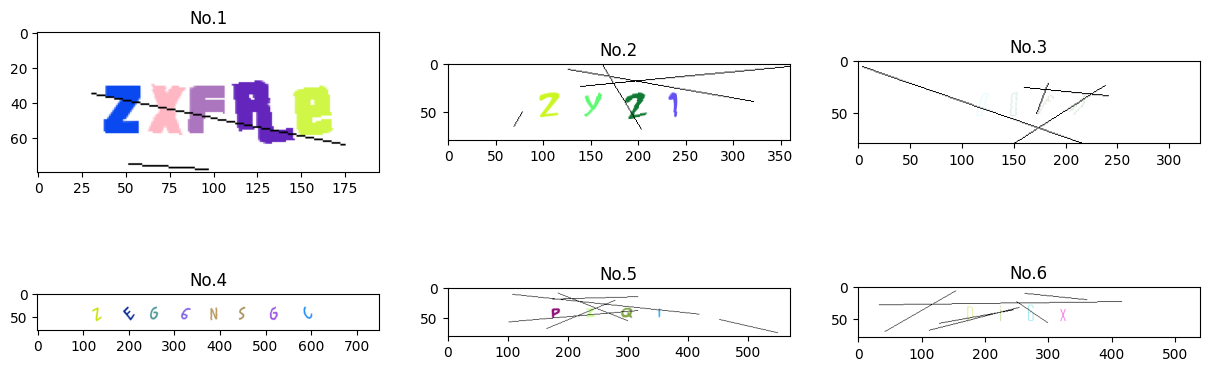

In [34]:
img_paths = ["../data/train/zxfre-0.png","../data/train/zyz1-0.png",
              "../data/train/00fh-0.png", "../data/train/zeg6nsgc-0.png", 
              "../data/train/pzqi-0.png", "../data/train/pi6x-0.png"]
imgs = []
for i, p in enumerate(img_paths):
    imgs.append(cv2.imread(p))

def plot(imgs):
    plt.figure(figsize=(15,5))
    for idx, img in enumerate(imgs):
        plt.subplot(2, 3, idx + 1), plt.imshow(img), plt.title(f"No.{idx+1}")
plot(imgs)

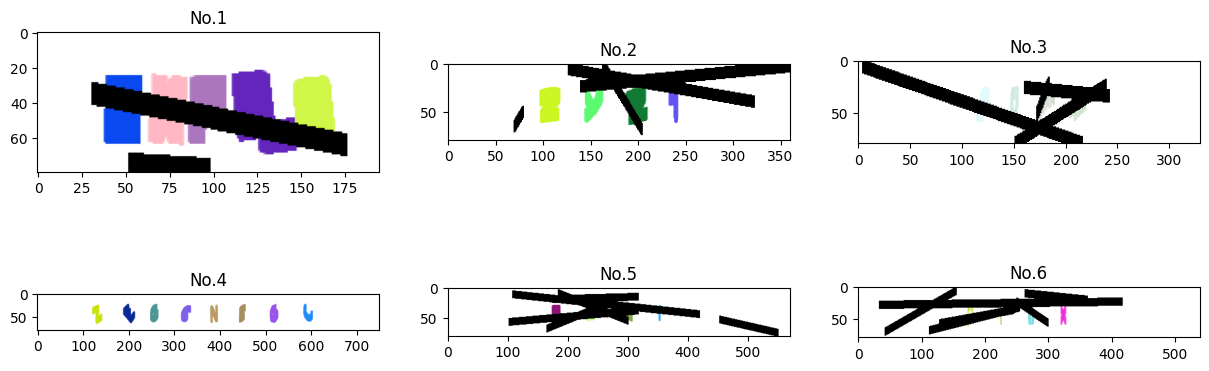

In [35]:
horizontal_line_filter_kernel = np.ones((13, 2), np.uint())
temps = []
for i, img in enumerate(imgs):
    temp = deepcopy(img)
    temps.append(cv2.erode(temp, horizontal_line_filter_kernel, iterations=1))
plot(temps)

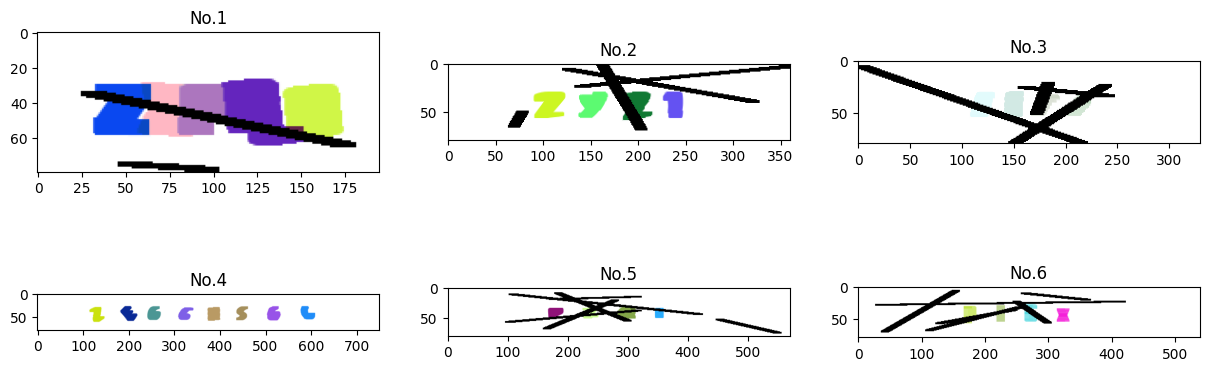

In [36]:
vertical_line_filter_kernel = np.ones((3, 13), np.uint())
temps = []
for i, img in enumerate(imgs):
    temp = deepcopy(img)
    temps.append(cv2.erode(temp, vertical_line_filter_kernel, iterations=1))
plot(temps)



In [37]:
def remove_horizontal(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=5)

    # Detect lines using Probabilistic Hough Transform
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, 100, minLineLength=50, maxLineGap=10)

    # Create a mask to mark lines for removal
    mask = np.zeros(img.shape[:2], dtype=np.uint8) 

    # Define an angle tolerance for "horizontal"
    # Horizontal is generally 0 degrees (0 radians) or 180 degrees (pi radians) 
    # in the Hough space, but Probabilistic HLT uses a different angle convention 
    # based on endpoints. We use arctan2 to get the line segment angle.

    angle_tolerance = 45 # degrees

    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]

            # Calculate the angle of the line segment in degrees
            angle_rad = np.arctan2(y2 - y1, x2 - x1) 
            angle_deg = np.degrees(angle_rad) % 180 # Normalize to 0-180 range

            # Check if the line is close to 0 or 180 (horizontal)
            # We need to account for both 0-degree and 180-degree near-horizontal lines
            is_horizontal = (angle_deg < angle_tolerance) or (angle_deg > 180 - angle_tolerance)

            if is_horizontal:
                # Draw the line onto the mask
                cv2.line(mask, (x1, y1), (x2, y2), 255, 3) 

    # Use Inpainting to remove the lines from the original image
    result = cv2.inpaint(img, mask, 3, cv2.INPAINT_TELEA)
    return result

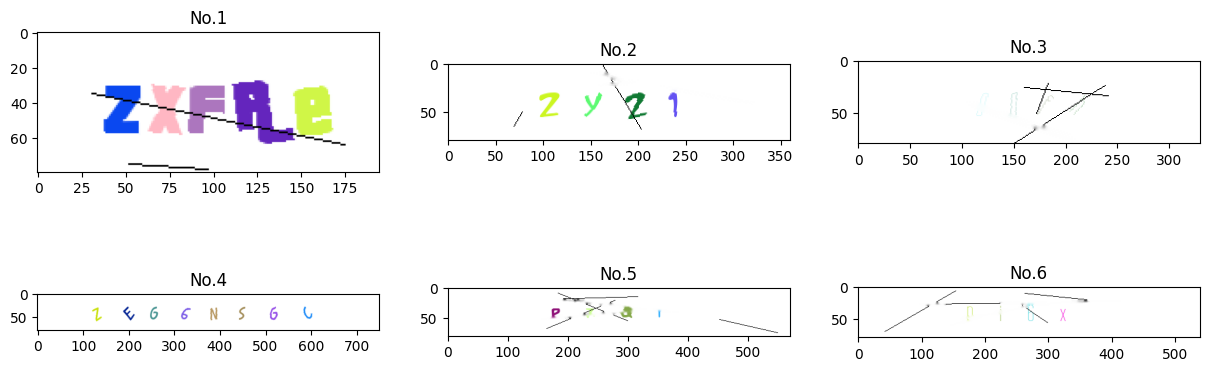

In [38]:
temps = []
for i, img in enumerate(imgs):
    temp = deepcopy(img)
    temps.append(remove_horizontal(temp))
plot(temps)


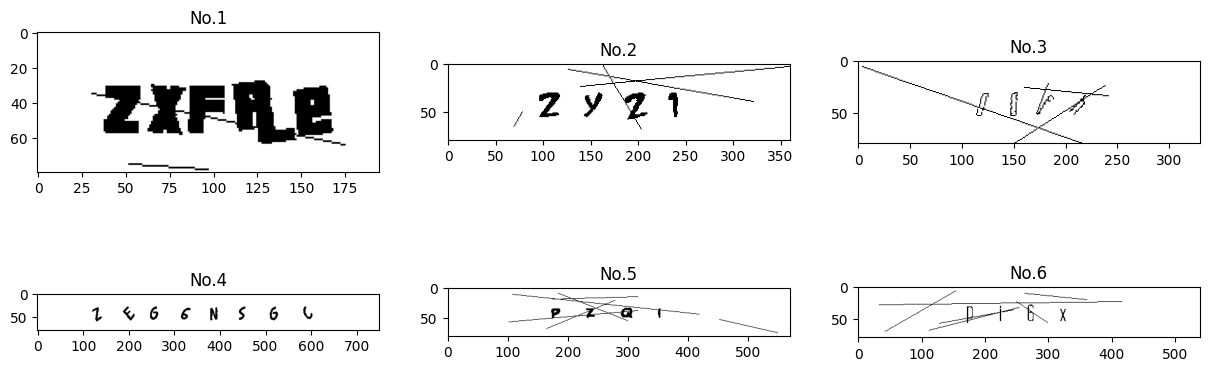

In [39]:
def make_non_white_black(img, white_threshold=240):
    """Convert non-white pixels to black"""
    # Convert to grayscale if needed
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    
    # Create binary mask: white pixels = 255, non-white = 0
    _, binary = cv2.threshold(gray, white_threshold, 255, cv2.THRESH_BINARY)
    
    # Convert back to 3-channel if original was 3-channel
    if len(img.shape) == 3:
        binary = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
    
    return binary

# Test with your images
binary_images = []
for i, img in enumerate(imgs):
    temp = make_non_white_black(img, white_threshold=250)  # Adjust threshold as needed
    binary_images.append(temp)
plot(binary_images)

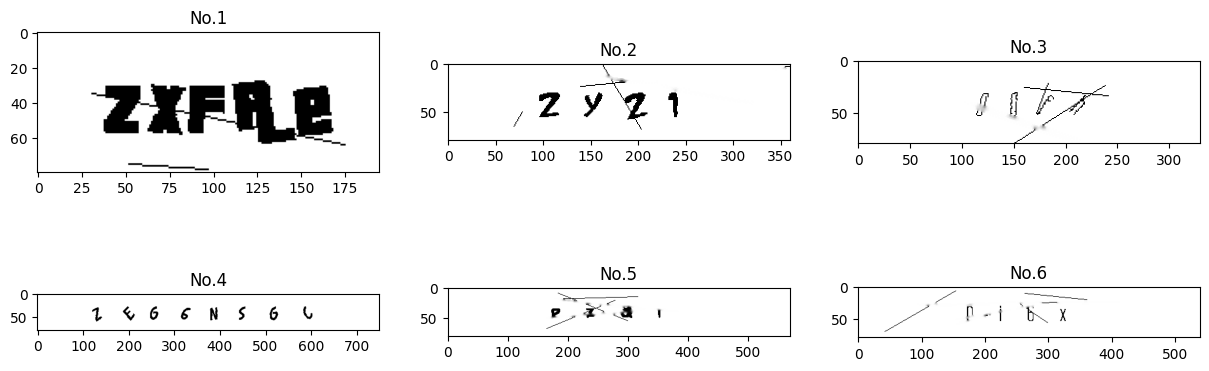

In [40]:
temps=[]
for i, img in enumerate(binary_images):
    temp = deepcopy(img)
    temps.append(remove_horizontal(temp))
plot(temps)

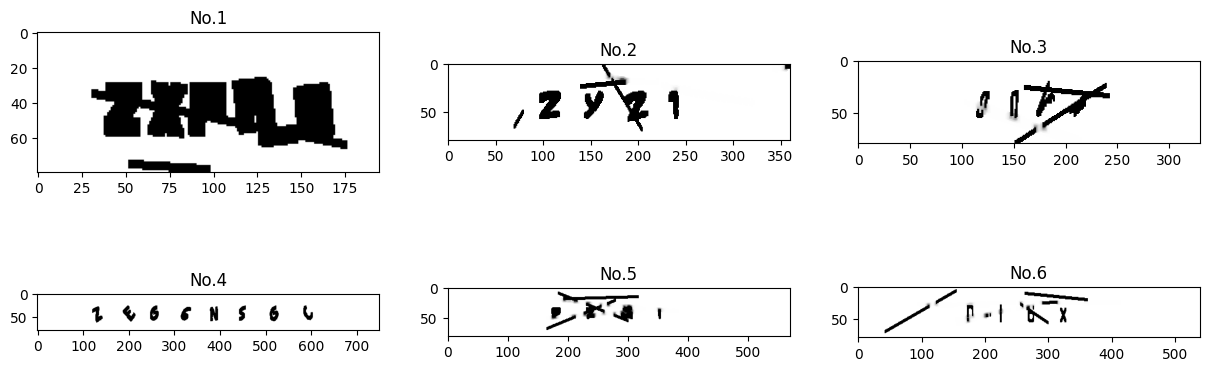

In [41]:
temps=[]
kernel = np.ones((5, 2), np.uint())
for i, img in enumerate(binary_images):
    temp = deepcopy(img)
    temp = remove_horizontal(temp)
    temp = cv2.erode(temp, kernel, iterations=1)
    # temps.append(cv2.medianBlur(temp, 3))
    temps.append(temp)
plot(temps)

In [42]:
def thicken_char(img):
    kernel = np.ones((5, 2), np.uint())
    img = remove_horizontal(img)
    t = cv2.erode(img, kernel, iterations=1)
    return t

In [43]:
cv2.imwrite("data/selected_test_class/00fh-1.png", temps[2])

False

In [44]:
MODEL_NAME = "best.pt"
from ultralytics import YOLO

yolo_model = YOLO(MODEL_NAME)

results = yolo_model.predict(source=temps[2], save=False, conf=0.5, iou=0.5)
if results and results[0].boxes:
    boxes = results[0].boxes.xyxy.cpu().numpy()
    print(boxes)


0: 160x640 3 chars, 12.7ms
Speed: 0.5ms preprocess, 12.7ms inference, 0.4ms postprocess per image at shape (1, 3, 160, 640)
[[     114.13       30.07      126.23      54.924]
 [     146.76       29.74      154.66      57.186]
 [     151.44      63.659      171.67          80]]


In [45]:
def get_bounding_boxes(img):
    MODEL_NAME = "best.pt"
    from ultralytics import YOLO

    yolo_model = YOLO(MODEL_NAME)

    results = yolo_model.predict(source=img, save=False, conf=0.5, iou=0.5)
    if results and results[0].boxes:
        ret = results[0].boxes.xyxy.cpu().numpy()
        print(f"char_len: {len(ret)}")
        return ret

In [46]:
def get_text_boundaries(boxes):
    """Get leftmost and rightmost coordinates from YOLO boxes"""
    if len(boxes) == 0:
        return None, None
    
    # boxes format: [[x1, y1, x2, y2], ...]
    left_edges = boxes[:, 0]   # All x1 values
    right_edges = boxes[:, 2]  # All x2 values
    
    leftmost = float(left_edges.min())
    rightmost = float(right_edges.max())
    
    return leftmost, rightmost

def clip_image_to_text(original_img, leftmost, rightmost, padding=10):
    """Clip original image to text boundaries with optional padding"""
    
    # Get image dimensions
    height, width = original_img.shape[:2]
    
    # Add padding and ensure within image bounds
    left_clip = max(0, int(leftmost - padding))
    right_clip = min(width, int(rightmost + padding))
    
    # Clip the image (keep full height, clip width)
    clipped_img = original_img[:, left_clip:right_clip]
    
    return clipped_img, (left_clip, right_clip)

In [47]:
def clip_image_using_yolo(img):
    temp = deepcopy(img)
    temp = make_non_white_black(temp, 250)
    temp = thicken_char(temp)
    boxes = get_bounding_boxes(temp)
    lm, rm = get_text_boundaries(boxes)
    if lm != None and rm != None:
        clipped_img, _ = clip_image_to_text(img, lm, rm)
        return clipped_img
    else:
        return img

# Using yolo to detect char and clipping is not effective as yolo's ability to detect is not great


0: 288x640 1 char, 20.7ms
Speed: 0.6ms preprocess, 20.7ms inference, 0.2ms postprocess per image at shape (1, 3, 288, 640)
char_len: 1

0: 160x640 5 chars, 11.4ms
Speed: 0.4ms preprocess, 11.4ms inference, 0.4ms postprocess per image at shape (1, 3, 160, 640)
char_len: 5

0: 160x640 3 chars, 11.6ms
Speed: 0.5ms preprocess, 11.6ms inference, 0.3ms postprocess per image at shape (1, 3, 160, 640)
char_len: 3

0: 96x640 8 chars, 7.9ms
Speed: 0.4ms preprocess, 7.9ms inference, 0.4ms postprocess per image at shape (1, 3, 96, 640)
char_len: 8

0: 96x640 4 chars, 7.6ms
Speed: 0.5ms preprocess, 7.6ms inference, 0.4ms postprocess per image at shape (1, 3, 96, 640)
char_len: 4

0: 96x640 5 chars, 8.1ms
Speed: 0.4ms preprocess, 8.1ms inference, 0.3ms postprocess per image at shape (1, 3, 96, 640)
char_len: 5


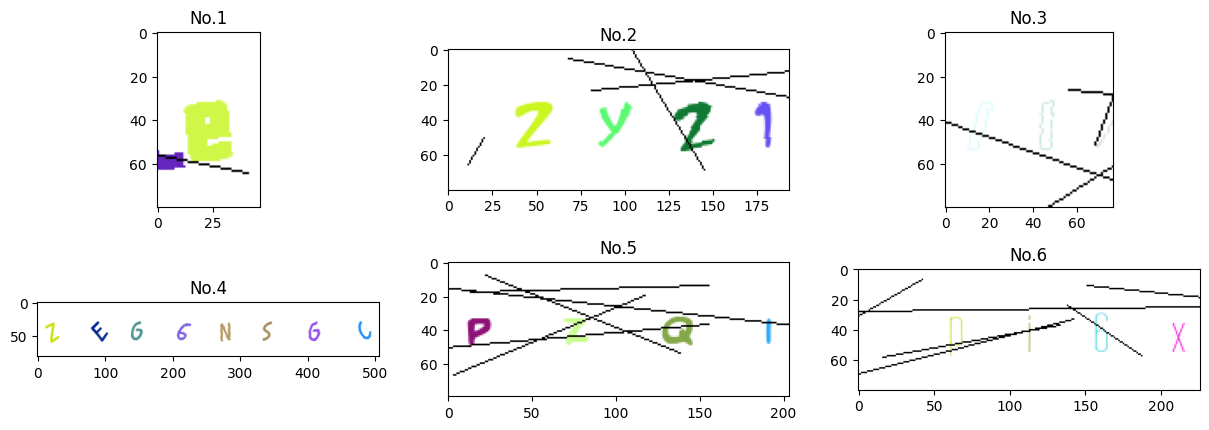

In [48]:
temps=[]
for i, img in enumerate(imgs):
    temp = deepcopy(img)
    temps.append(clip_image_using_yolo(temp))
plot(temps)


0: 160x640 3 chars, 12.9ms
Speed: 0.5ms preprocess, 12.9ms inference, 0.3ms postprocess per image at shape (1, 3, 160, 640)
char_len: 3


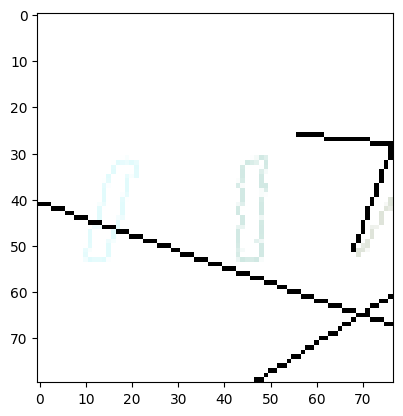

In [49]:
temp = clip_image_using_yolo(imgs[2])
plt.imshow(temp)

# Clipping image using hough transform and binarization works well on handful sample test

In [50]:
def get_lm_rm(img):
    """Get leftmost and rightmost coordinates using image processing (no YOLO)"""
    if len(img.shape) == 3:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        gray = img.copy()
    
    content_mask = gray < 255
    
    if not np.any(content_mask):
        return None, None
    
    content_cols = np.any(content_mask, axis=0)
    
    if not np.any(content_cols):
        return None, None
    
    leftmost = float(np.argmax(content_cols))
    rightmost = float(len(content_cols) - 1 - np.argmax(content_cols[::-1]))  # Last column with content
    
    return leftmost, rightmost

def clip_image_normal(img):
    temp = deepcopy(img)

    temp = make_non_white_black(temp, 250)
    p1 = deepcopy(temp)
    temp = remove_horizontal(temp)
    p2 = deepcopy(temp)
    lm, rm = get_lm_rm(temp)
    if lm == None and rm == None:
        return img, p1, p2
    else:
        clipped_img, _  = clip_image_to_text(img, lm, rm)
        return clipped_img, p1, p2

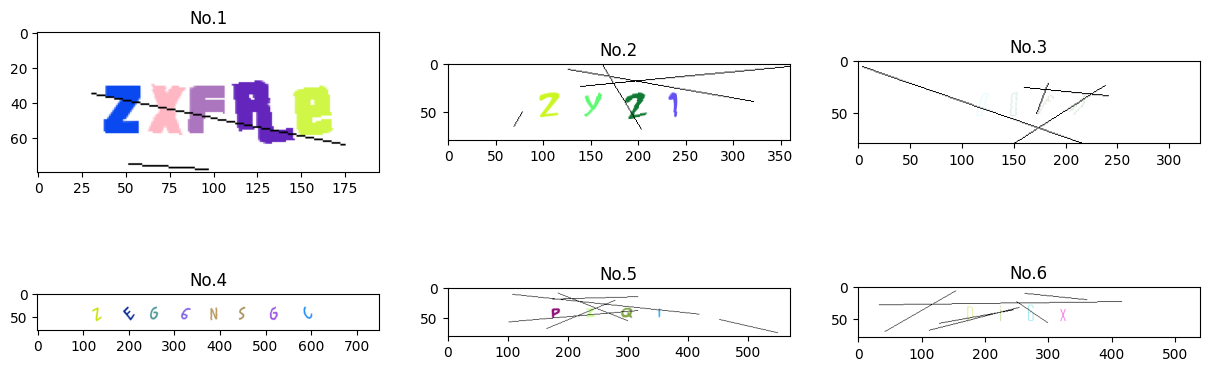

In [51]:
plot(imgs)

In [52]:
temps=[]
p1s = []
p2s = []
for i, img in enumerate(imgs):
    temp = deepcopy(img)
    clipped, p1, p2 = clip_image_normal(temp)
    temps.append(clipped)
    p1s.append(p1)
    p2s.append(p2)


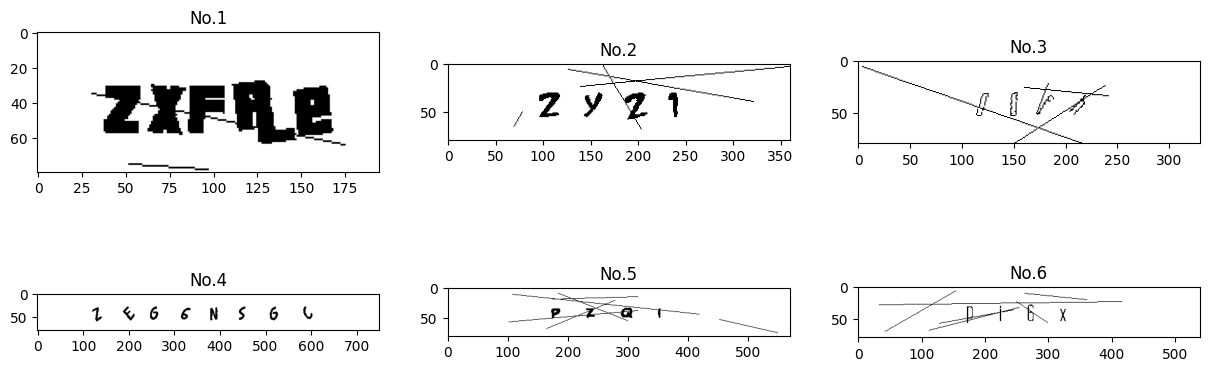

In [53]:
plot(p1s)

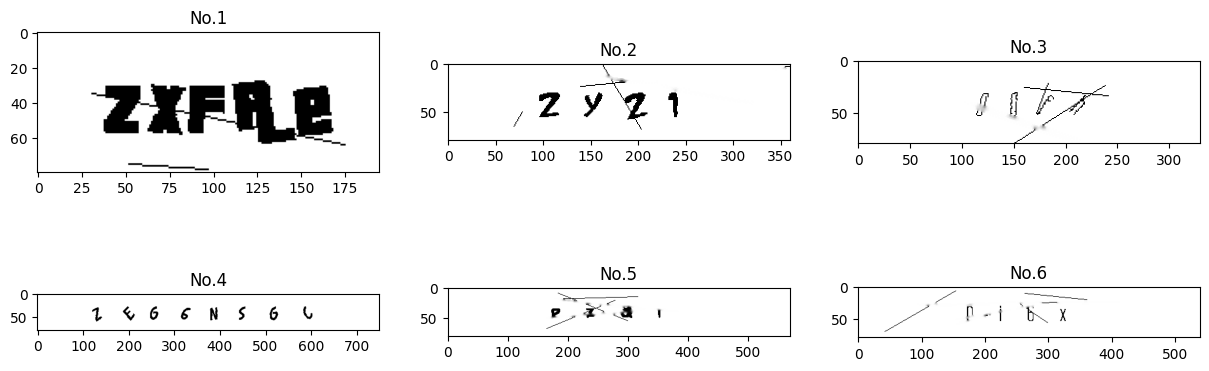

In [54]:
plot(p2s)

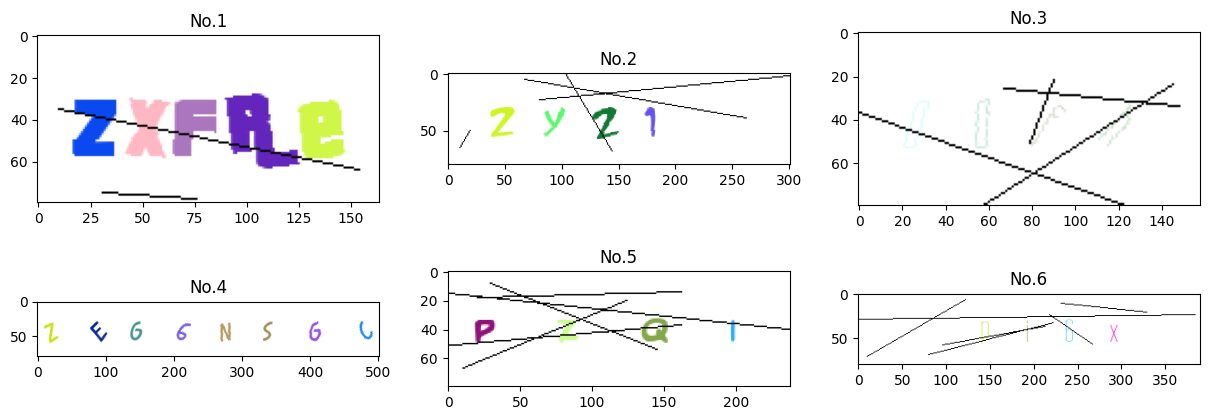

In [55]:
plot(temps)

In [56]:
print(temps[2].shape)

(80, 158, 3)


# Resizing with padding

In [65]:
def resize_with_padding(img,  target_height, target_width, padding_color=255):
    """
    Resize image to target dimensions while preserving aspect ratio.
    Add padding to fill the remaining space.
    
    Args:
        img: Input image
        target_width: Desired width
        target_height: Desired height
        padding_color: Color for padding (255=white, 0=black, [B,G,R] for color)
    """
    h, w = img.shape[:2]
    
    # Calculate scale to fit within target dimensions
    scale = min(target_width / w, target_height / h)
    
    # Calculate new dimensions
    new_width = int(w * scale)
    new_height = int(h * scale)
    
    # Resize image
    resized = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)
    
    # Create canvas with target dimensions
    if len(img.shape) == 3:  # Color image
        if isinstance(padding_color, int):
            canvas = np.full((target_height, target_width, 3), padding_color, dtype=np.uint8)
        else:
            canvas = np.full((target_height, target_width, 3), padding_color, dtype=np.uint8)
    else:  # Grayscale
        canvas = np.full((target_height, target_width), padding_color, dtype=np.uint8)
    
    # Calculate position to center the resized image
    y_offset = (target_height - new_height) // 2
    x_offset = (target_width - new_width) // 2
    
    # Place resized image on canvas
    canvas[y_offset:y_offset + new_height, x_offset:x_offset + new_width] = resized
    
    return canvas, (x_offset, y_offset, new_width, new_height)

(50, 300, 3)
(50, 300, 3)
(50, 300, 3)
(50, 300, 3)
(50, 300, 3)
(50, 300, 3)


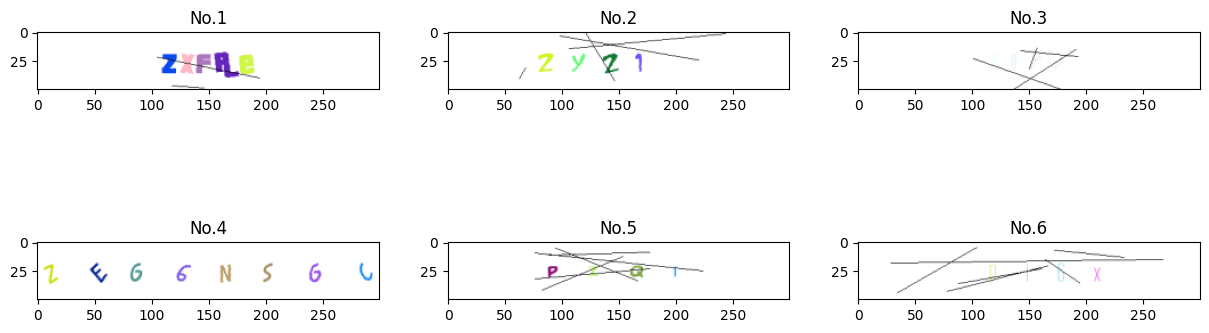

In [71]:
ts = []
for i, img in enumerate(temps):
    temp = deepcopy(img)
    temp, _ = resize_with_padding(temp, 50, 300)
    ts.append(temp)
for t in ts:
    print(t.shape)
plot(ts)